# Баесовские Модели: Нормализация Данных и Квадратичная Функция ошибки

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
from IPython.core.pylabtools import figsize
plt.style.use(['science', 'notebook', 'grid'])

Попытаемся обучить обручную линейную регрессию $x \cdot w_0+x^2 \cdot w_1+ b = y \ \Rightarrow \ Xw = y$, в качестве функции ошибки возьмем среднее квадратов отклонений $MSE = E[\ \|Xw-y\|^2\ ]$

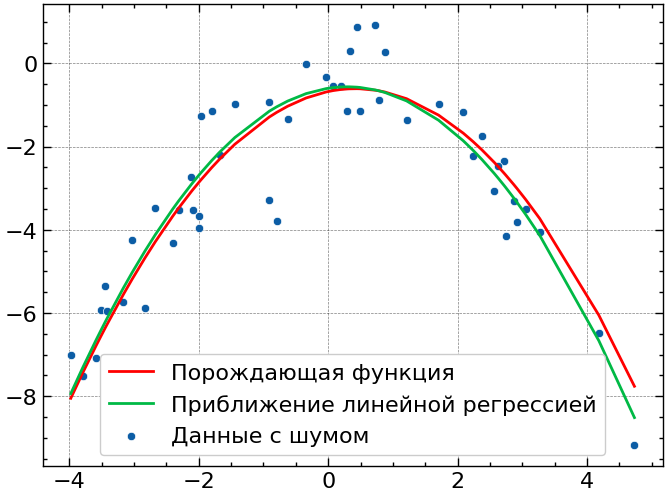

In [2]:
np.random.seed(42)

n = 50
# Создаем двумерный массив x с двумя столбцами: первый столбец - линейное пространство с шумом, второй - единицы
X = np.linspace(-4, 4, n).reshape(-1, 1) + np.random.randn(n,1)
X = np.hstack([X, X**2, np.ones((n, 1))])

# Генерируем вектор весов w и вектор шума epsilon
w = np.random.randn(3, 1)
epsilon = np.random.randn(n, 1)

# Вычисляем y как линейную комбинацию x и w с добавлением шума epsilon
y = X @ w + epsilon

w_mse = np.linalg.inv(X.T@X)@X.T@y

# Строим прямую из которой порождались точки
sns.lineplot(x=X[:, 0], y=(X @ w)[:, 0], color='red', linewidth=2, label='Порождающая функция')
sns.lineplot(x=X[:, 0], y=(X @ w_mse)[:, 0], color='C1', linewidth=2, label='Приближение линейной регрессией')

# Строим точки данных
sns.scatterplot(x=X[:, 0], y=y[:, 0], label='Данные с шумом')

plt.show()

In [3]:
w_mse

array([[ 0.23907294],
       [-0.40426246],
       [-0.59872844]])

In [4]:
import tensorflow as tf

X_tensor = tf.constant(X, dtype=tf.float32) 
y_tensor = tf.constant(y, dtype=tf.float32)

model = tf.keras.Sequential([ tf.keras.layers.Dense(units=1, input_shape=(3,), use_bias=False) ])

model.compile(optimizer=tf.optimizers.RMSprop(), loss='mean_squared_error')

model.set_weights(np.array([[[-0.5],[0.5],[0.5]]]))

In [14]:
model.fit(X_tensor, y_tensor, epochs=1000, verbose = False)
model.get_weights()

[array([[ 0.240064  ],
        [-0.40368658],
        [-0.6011443 ]], dtype=float32)]

Можно посмотреть на графике как она обучается

![training](assets/training_2.gif)

Попробуем разложить $MSE$ по компонентам:
<br>
Так как $E[X^2] = Var[X] + E[X]^2$
<br>
Средняя квадратичная ошибка:
<br>
$MSE = E[(\hat{y} - y)^2] = Var[\hat{y} - y] + E[\hat{y}-y]^2 = Var[\hat{y} - f(x)] + E[\hat{y}-f(x)]^2 + Var[\epsilon]$
<br>
$MSE = Var[\hat{y} - f(x)] + Bias^2 + Error^2$

Прошу заметить что на большинстве ресурсов в интернете указана формула $MSE= Var[\hat{y}]+Bias^2+Error^2$ что не может являтся правдой так как $f(x)$ зависит от x так-же как и $\hat{y}=Xw$ значит они зависят друг от друга и их $Cov(f(x),\hat{y}) \neq 0$ и тем более эмпирическая дисперсия $Var[f(x)]\neq 0$, дело в том что на этих ресурсах почему-то указывают $f(x)$ константой, но $f(x)$ является константой только при фиксированном $x$, а когда $x$ фиксирован, $\hat{y}=Xw$ также является константой и никакой дисперсии нет

Если мы обручем модель только на $Var[\hat{y}-y]$ тогда у нас обучаются только веса $w_i$, которые отвечают за наклон гиперплоскости в линейном пространстве, и смещение никак не влияет на ошибку, так как $Var[x+const]= Var[x] \ \Rightarrow \ Var[\hat{y}-y] = Var[Xw+ b-y]= Var[Xw -y] $
<br>
<br>
$Var[Xw -y] = E[\ \|Xw - y - E[Xw - y]\ \|^2\ ]= \frac{1}{m} \|Xw - y- (\mu_x\mu_x^Tw - \mu_y I)\|^2=\frac{1}{m}((X- \mu_x\mu_x^T)w - y- \mu_y I)^T((X- \mu_x\mu_x^T)w - y- \mu_y I)$
<br>
<br>
$Var[Xw -y] = w^T COV_Xw - 2w^T Cov_{X,y} + Var[y]$
<br>
<br>
$\nabla Var[Xw -y] = 2COV_Xw - 2w^T Cov_{X,y} = 0 \Rightarrow w = COV_X^{-1}Cov_{X,y}$
<br>
<br>
Где $\mu_x$ - вектор средних по столбцам $X$,

$\mu_y$ - среднее $y$, 

$I$ вектор из едениц = $\begin{bmatrix}
        \ 1 \ \\
        \ 1 \ \\
        \ \vdots \ \\
        \ 1 \ 
    \end{bmatrix}$,

$COV_X = \frac{1}{m}(X- \mu_x\mu_x^T)^T(X- \mu_x\mu_x^T)$ - матрица ковариаций по столбцам $X$,

$Cov_{X, y} = \frac{1}{m}(X- \mu_x\mu_x^T)^T(y-\mu_y)$ - вектор ковариаций каждого столбца $x$ с вектором $y$

$Var[y] = \frac{1}{m} (y- \mu_y I)^T(y- \mu_y I)$ - дисперсия $y$

Снова прошу заметить что если бы мы использовали Variance из ресурсов в интернете как $Var[\hat{y}]=Var[Xw]$ у нас бы ошибка просто зануляла веса

In [6]:
def custom_loss_function_std(y_true, y_pred):
    return tf.math.reduce_std(y_pred - y_true)

# Модель
model_std = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=(3,), use_bias=False)
])

# Функция потерь и оптимизатор
model_std.compile(optimizer=tf.optimizers.RMSprop(), loss=custom_loss_function_std)

model_std.set_weights(np.array([[[-0.5],[0.5],[0.5]]]))

In [15]:
model_std.fit(X_tensor, y_tensor, epochs=1000, verbose = False)
model_std.get_weights()

[array([[ 0.23520707],
        [-0.40825194],
        [ 0.5000032 ]], dtype=float32)]

![training](assets/training_3.gif)

А ошибка $Bias^2 = E[\hat{y}-y]^2$ в основной части обучает смещение:
<br>
$Bias^2 = E[Xw-y]^2 = (\mu_x^Tw - \mu_y)^2$

$\nabla Bias^2 = 2\mu_x\mu_x^T w - 2\mu_y \mu_x = 0 \ \Rightarrow \ \mu_x^T w = \mu_y$
<br>

Что дает бесконечно много решений, и при правильных весах $w_i$ обучает правильное смещение $b$

In [8]:
def custom_loss_function_sqr_mean(y_true, y_pred):
    return tf.math.square(tf.reduce_mean(y_pred - y_true))

model_mean = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=(3,), use_bias=False)
])

model_mean.compile(optimizer=tf.optimizers.RMSprop(), loss=custom_loss_function_sqr_mean)

model_mean.set_weights(np.array([[[-0.5],[0.5],[0.5]]]))

In [16]:
model_mean.fit(X_tensor, y_tensor, epochs=1000, verbose = False)
model.get_weights()

[array([[ 0.240064  ],
        [-0.40368658],
        [-0.6011443 ]], dtype=float32)]

![training](assets/training_4.gif)

Если подумать, то нормализуя данные ($x_i^{normal} = \frac{x_i-\mu_{x_i}}{\sigma_{x_i}}$) тогда значение $Bias^2 = E[Xw-y]^2 = (\mu_x^Tw - \mu_y)^2$ так как mu_x_i =0 и \mu_y = 0 будет всегда равно $b^2$ которое минимизируется при $b=0$ и нам не нужно больше использовать смещение, что упрощает вычисления

Более того в ошибке $Var[Xw -y] = w^T COV_Xw - 2w^T Cov_{X,y} + Var[y]$ матрицы ковариаций превращаются в матрицы корреляций, а дисперсия $y$ будет равна единице, более того марица корреляций $CORR_X= \frac{1}{m}X^TX$, $Corr_{X,y} = X^Ty$

Проверим как происходит переход между $w_{true}$ и $w_{normal}$ зная что $b_{normal}=0$ из рассуждений выше: 

\begin{align*}
    \begin{bmatrix}
            \frac{1}{\sigma_{x_1}} & 0 & \dots & 0 \\
            0 & \frac{1}{\sigma_{x_2}} & \dots & 0 \\
            \vdots & \vdots & \ddots & \vdots \\
            0 & 0 & \dots & \frac{1}{\sigma_{x_n}}
        \end{bmatrix}
        \begin{bmatrix}
            x_{11} - \mu_{x_1} & x_{12} - \mu_{x_2}& \dots & x_{1n} - \mu_{x_n} \\
            x_{21} - \mu_{x_1} & x_{22} - \mu_{x_2}& \dots & x_{2n} - \mu_{x_n} \\
            \vdots & \vdots & \ddots & \vdots \\
            x_{m1} - \mu_{x_1} & x_{m2} - \mu_{x_2}& \dots & x_{mn} - \mu_{x_n}
        \end{bmatrix}
        \begin{bmatrix}
            w_{1} \\
            w_{2} \\
            \vdots\\
            w_{n}
        \end{bmatrix} = \frac{1}{\sigma_y}
        \begin{bmatrix}
            y_{1}-\mu_y \\
            y_{2} - \mu_y \\
            \vdots\\
            y_{m} - \mu_y
        \end{bmatrix}
\end{align*}


$$\Sigma^{-1}(X-\mu_x \mu_x^T)w_{normal} = \sigma_y^{-1}(y-\mu_yI)$$

$$\sigma_y\Sigma^{-1}Xw_{normal} - \sigma_y\mu_x \mu_x^Tw_{normal} + \mu_yI = y$$   

$$Xw_{true} + b = y$$

$$w_{true} = \sigma_y \Sigma^{-1}w_{normal} \Rightarrow w_{normal} =\sigma_y^{-1}\Sigma w_{true}$$

$$b = \mu_x \mu_x^T\Sigma w_{true} + \mu_yI$$

Можно заметить что $w_{normal_i} = \frac{\sigma_{x_i}}{\sigma_{y}}w_{true_i}$  когда $\sigma_{x_i}>\sigma_y$ значения весов увеличиваются, а когда $\sigma_{x_i}<\sigma_y$, уменьшается, и при больших изначальных весовых коэффициентах $\sigma_y >> \sigma_{x_i}$, и большинсво весовых коэффициентов будут стягиватся к нулю, что ускоряет процесс машинного обучения, так как большинсво библиотек задает изначальные веса из нормального распределения вблизи 0

<Axes: >

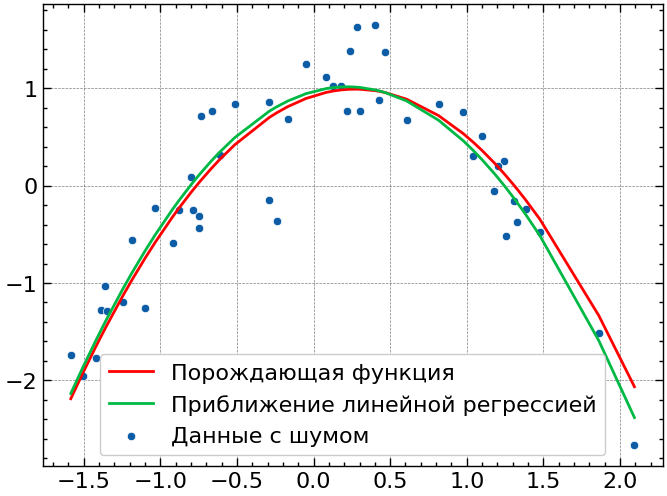

In [17]:
std_y = np.std(y)
mean_y = np.mean(y)
y_normalize = (y - mean_y)/std_y

X_normalize = np.empty((n,2))
w_normalize = np.empty((2,1))

std_x1 = np.std(X[:,0])
mean_x1 = np.mean(X[:,0])
X_normalize[:,0] = (X[:,0] - mean_x1)/std_x1

std_x2 = np.std(X[:,1])
mean_x2 = np.mean(X[:,1])
X_normalize[:,1] = (X[:,1] - mean_x2)/std_x2

std_matrix = np.array([[std_x1, 0], [0, std_x2]])

w_normalize = std_matrix @ w[:2] / std_y

w_mse_normalize = np.linalg.inv(X_normalize.T@X_normalize)@X_normalize.T@y_normalize

sns.lineplot(x=X_normalize[:, 0], y=(X_normalize @ w_normalize)[:, 0], color='red', linewidth=2, label='Порождающая функция')
sns.lineplot(x=X_normalize[:, 0], y=(X_normalize @ w_mse_normalize)[:, 0], color='C1', linewidth=2, label='Приближение линейной регрессией')

sns.scatterplot(x=X_normalize[:, 0], y=y_normalize[:, 0], label='Данные с шумом')

In [11]:
w_mse_normalize, w_mse

(array([[ 0.24157718],
        [-0.89928582]]),
 array([[ 0.23907294],
        [-0.40426246],
        [-0.59872844]]))

In [12]:
X_tensor_normalize = tf.constant(X_normalize, dtype=tf.float32)
y_tensor_normalize = tf.constant(y_normalize, dtype=tf.float32)

model_normalize = tf.keras.Sequential([ tf.keras.layers.Dense(units=1, input_shape=(2,), use_bias=False) ])

model_normalize.compile(optimizer=tf.optimizers.RMSprop(), loss='mean_squared_error')

model_normalize.set_weights(np.array([[[-0.5],[0.5]]]))

In [19]:
model_normalize.fit(X_tensor_normalize, y_tensor_normalize, epochs=1000, verbose = False)
model_normalize.get_weights()

[array([[ 0.24164729],
        [-0.8980229 ]], dtype=float32)]

![training](assets/training_5.gif)